# Modelo de puntuación de impago
## Librerías necesarias:
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from optbinning import Scorecard, BinningProcess, OptimalBinning
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

(CVXPY) Mar 16 01:46:16 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Mar 16 01:46:16 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


# Datos
## Carga de datos
---

In [65]:
dt=pd.read_excel('DatosPractica_Scoring.xlsx')
dt.head()

,ID,Cardhldr,default,Age,Income,Exp_Inc,Avgexp,Ownrent,Selfempl,Depndt,Inc_per,Cur_add,Major,Active
0,1,1.0,0.0,27.08333,2.400,0.016798,33.01333,0,0,0,2.400000,56,1,1
1,2,1.0,1.0,24.25000,3.500,0.069963,203.89170,0,0,0,3.500000,60,1,11
2,3,0.0,NaN,27.41667,1.600,0.000750,0.00000,1,0,1,0.800000,30,0,0
3,4,1.0,0.0,40.33333,3.067,0.159700,408.08250,0,0,2,1.022333,18,0,0
4,5,1.0,0.0,28.16667,3.350,0.071625,199.36920,1,0,0,3.350000,18,1,2


## Descripción de los datos
---
**Default**: Variable objetivo, indica si un cliente ha hecho impago durante la ventana de observación.
Default = 1 if defaulted 0 if not (observed only when Cardhldr = 1)

**Cardhldr=1**: Clientes aceptados, son clientes a los que se le ha dado la tarjeta de crédito (Cardhldr=1) y sobre los que sabemos si han impagado alguna vez o no (default= 1 o 0 respectivamente).

**Cardhldr=0**: clientes rechazados, son clientes que solicitaron un crédito pero a los que se negó su solicitud (Cardhldr=0), son clientes a los que no se les concedió la tarjeta, y por tanto no sabemos si hubieran impagado o no (default= na) porque no se les concedió la tarjeta de crédito.

**(Cardhldr=na)**: solicitud de nuevos clientes que solicitan una tarjeta de créditos y que hay que puntuar. Estos clientes están al final del archivo, son los 34 nuevos potenciales clientes (Cardhldr=na) con identificador de cliente desde 1286 hasta 1319, que están solicitando una tarjeta de crédito. Vosotros tendréis que puntuar su calidad crediticia y concederles o no el préstamo.

## Variables
---
ID: identificador de cada solicitante de tarjeta

Age = Edad n años más doceavos de año

Income = Ingreso anual (dividido por 10,000)

Exp_Inc = Relación entre el gasto mensual de la tarjeta de crédito y el ingreso anual

Avgexp = Gasto promedio mensual con tarjeta de crédito

Ownrent = 1 si es dueño de su casa, 0 si alquila

Selfempl = 1 si es autónomo, 0 si no.

Depndt = número de dependientes (personas a cargo)

Inc_per = Ingreso dividido por (1+número de dependientes)

Cur_add = meses viviendo en la dirección actual

Major = número de las principales tarjetas de crédito retenidas

Active = número de cuentas de crédito activas

# Enunciado
---

Suponga que toma todos los clientes Aceptados y hace un primer análisis exploratorio sin depurar, ni transformar ninguna de las variables explicativas, y utilizando todas las observaciones del fichero (los 994 clientes aceptados, esto es sin dividir la muestra para entrenamiento y test).

Por favor indique a continuación cual es el Valor de la información de cada una de esas variables potencialmente predictoras

## Cardhldr

Divido el dataset en 3: 
    
   - Clientes aceptados
   - Clientes rechazados
   - Nuevos clientes

In [66]:
aceptados = pd.DataFrame(dt.loc[dt['Cardhldr']==1])
aceptados.drop(['Cardhldr'],axis=1,inplace=True)
aceptados.head()

,ID,default,Age,Income,Exp_Inc,Avgexp,Ownrent,Selfempl,Depndt,Inc_per,Cur_add,Major,Active
0,1,0.0,27.08333,2.4000,0.016798,33.01333,0,0,0,2.400000,56,1,1
1,2,1.0,24.25000,3.5000,0.069963,203.89170,0,0,0,3.500000,60,1,11
3,4,0.0,40.33333,3.0670,0.159700,408.08250,0,0,2,1.022333,18,0,0
4,5,0.0,28.16667,3.3500,0.071625,199.36920,1,0,0,3.350000,18,1,2
6,7,1.0,23.25000,1.8769,0.353630,553.10670,0,0,0,1.876900,12,1,3


In [67]:
nuevos = pd.DataFrame(dt.loc[dt['Cardhldr'].isna()])
nuevos.drop(['Cardhldr'],axis=1,inplace=True)
nuevos.head()

,ID,default,Age,Income,Exp_Inc,Avgexp,Ownrent,Selfempl,Depndt,Inc_per,Cur_add,Major,Active
1285,1286,NaN,27.00000,2.675,0.034820,77.28667,1,0,0,2.675000,135,1,0
1286,1287,NaN,27.58333,5.500,0.220473,1010.50200,0,1,0,5.500000,72,1,11
1287,1288,NaN,31.25000,5.000,0.074378,309.91000,1,0,2,1.666667,12,1,12
1288,1289,NaN,25.25000,2.880,0.041061,98.46416,0,0,0,2.880000,7,1,0
1289,1290,NaN,30.00000,1.850,0.107582,165.85500,0,0,0,1.850000,60,1,12


In [68]:
rechazados = pd.DataFrame(dt.loc[dt['Cardhldr']==0])
rechazados.drop(['Cardhldr'],axis=1,inplace=True)
rechazados.head()

,ID,default,Age,Income,Exp_Inc,Avgexp,Ownrent,Selfempl,Depndt,Inc_per,Cur_add,Major,Active
2,3,NaN,27.41667,1.600,0.000750,0.0,1,0,1,0.800,30,0,0
5,6,NaN,34.25000,1.944,0.000617,0.0,0,0,1,0.972,54,1,1
8,9,NaN,22.66667,1.500,0.000800,0.0,0,0,3,0.375,14,1,4
12,13,NaN,34.75000,2.670,0.000449,0.0,0,0,0,2.670,51,1,25
15,16,NaN,41.83333,3.500,0.000343,0.0,0,0,0,3.500,54,1,0


## Variable objetivo y variables explicativas

In [69]:
# 1) Definimos la lista de nombres señalando cuáles de ellas son las categóricas
Y = aceptados['default'].values
X = aceptados.drop(['default'],axis=1) #todas menos la primera que es el ID y la variable y
list_variables = X.columns.values.tolist()

## Criterio de selección

In [70]:
# 2) Definimos el criterio de selección, valor de la información es > 0,2
selection_criteria = {
    "iv": {"min": 0.02, "max": 1}
}

## Tramificación

In [71]:
# 3) Definimos el proceso de Tramificación o BinningProcess
binning_process = BinningProcess(
    variable_names=list_variables,
    selection_criteria=selection_criteria)

In [72]:
# 4) Obtenemos los tramos óptimos de todas las Variables
dt_train_binned = binning_process.fit(X, Y)

In [73]:
dt_train_binned.summary().sort_values('iv')

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
7,Depndt,numerical,OPTIMAL,False,4,0.005121,0.00064,0.035048,0.000135
6,Selfempl,numerical,OPTIMAL,False,2,0.011895,0.001478,0.028111,0.005643
5,Ownrent,numerical,OPTIMAL,False,2,0.011976,0.001496,0.054689,0.02354
10,Major,numerical,OPTIMAL,True,2,0.030557,0.003792,0.059399,0.039958
0,ID,numerical,OPTIMAL,True,6,0.066643,0.008154,0.099136,0.000337
8,Inc_per,numerical,OPTIMAL,True,7,0.15624,0.018334,0.183395,0.025607
3,Exp_Inc,numerical,OPTIMAL,True,5,0.187134,0.02197,0.191595,0.194671
9,Cur_add,numerical,OPTIMAL,True,6,0.192857,0.023537,0.232347,0.002619
2,Income,numerical,OPTIMAL,True,5,0.222999,0.026768,0.215741,0.055953
1,Age,numerical,OPTIMAL,True,7,0.224977,0.026616,0.236603,0.021707


---
---
## Enunciado
Con toda esta información, y considerando tanto a los clientes Aceptados, como a los Rechazados (haciendo inferencia de rechazados), realice un pronóstico para las solicitudes de los nuevos clientes (los clientes con un ID desde el 1286 hasta 1319). Se recomienda realizar un análisis exploratorio previo para depurar los datos que se van a utilizar en la estimación de los modelos (depuración de datos atípicos, variables con poca variabilidad, transformación de variables), y dividir la muestra para entrenamiento y test para validar sus modelos).

Por favor indique a continuación a cuales de las siguientes 25 nuevas solicitudes SÍ concede el crédito (marque todas las solicitudes a las que concedería el crédito)

Calcula todos los posibles asociaciones entre todas las variables entre todas las variables. Está normalizado, esto no sirve para nada 

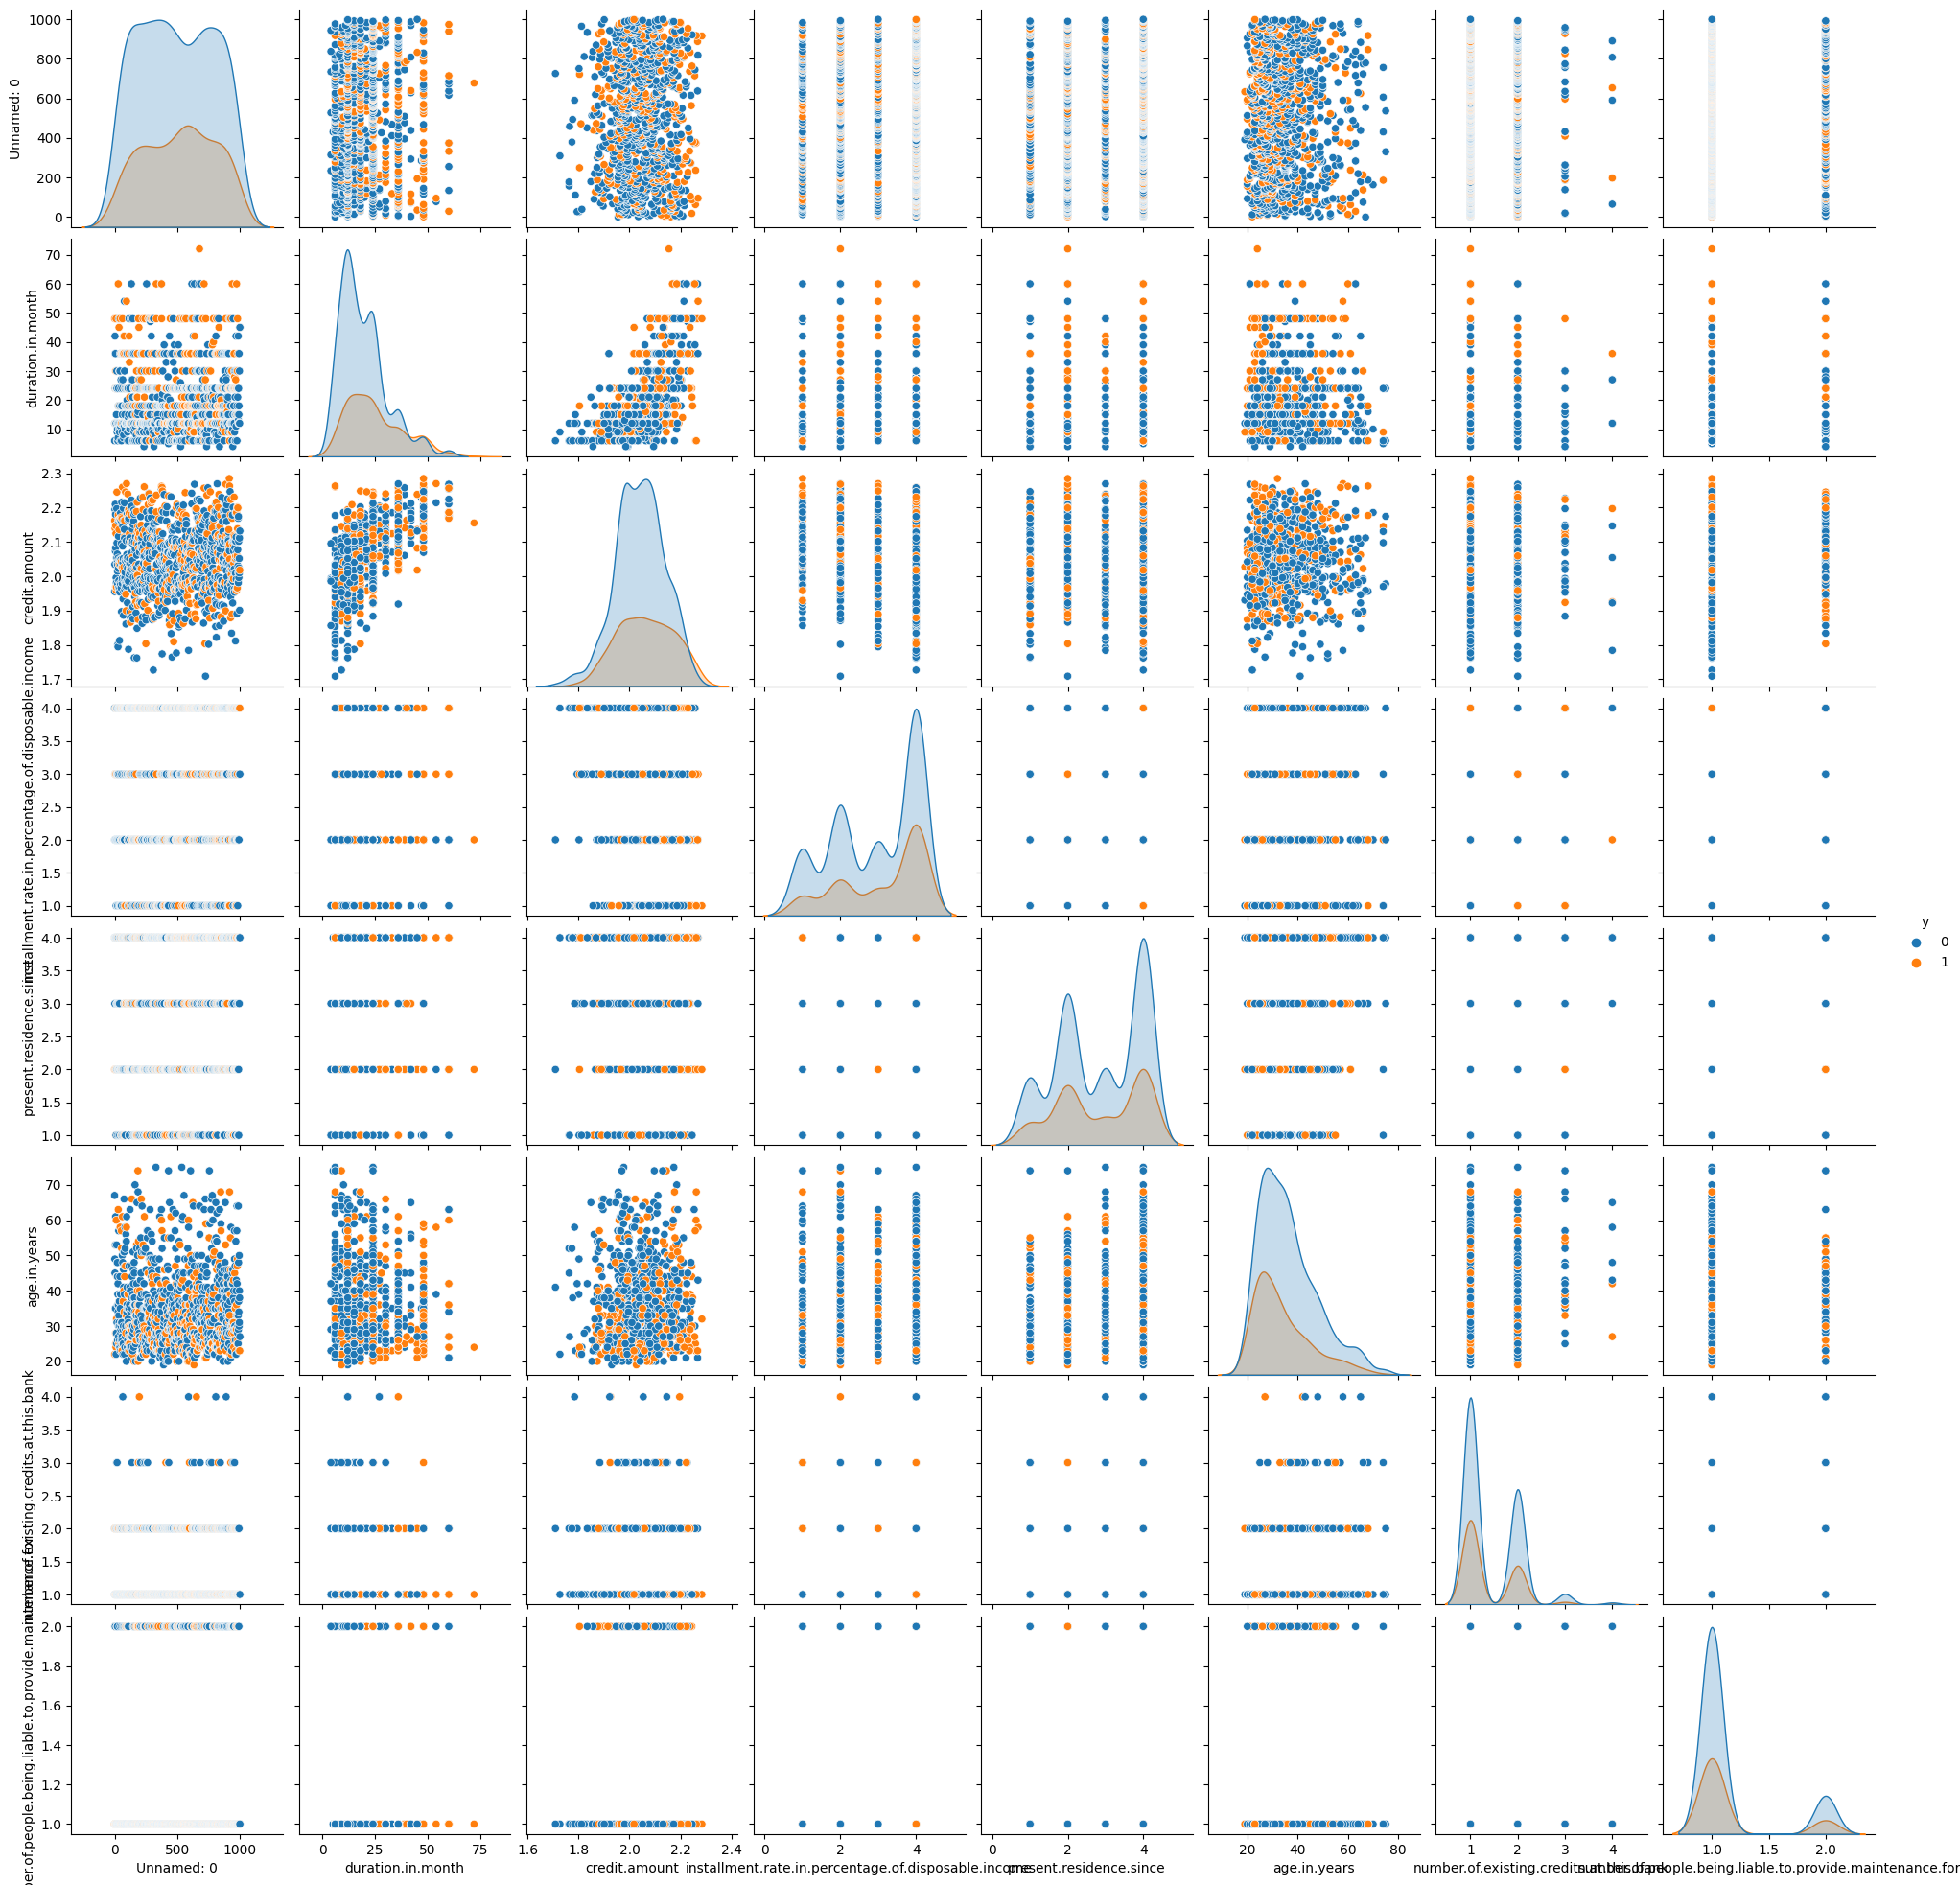

In [42]:
sns.pairplot(dt, hue="y")

---
---
# Análisis concentración 

Para seleccionar las variables más **importantes** para meter en el modelo

### Dividimos la muestra en entrenamiento y test
Con estratificación de la variable y, para que en cada partición haya un 30%  de malos

In [43]:
dt_train, dt_test = train_test_split(dt,stratify=dt["y"], test_size=.25, random_state=1234)

In [44]:
dt_train["y"].shape

(750,)

Porcentaje de 1 de la muestra

In [45]:
dt_train["y"].mean()

0.3

In [46]:
dt_test["y"].shape

(250,)

In [47]:
dt_test["y"].mean()

0.3

---
---
# Tramificación Óptima

## Tramificación de la Variable: "credit.amount"

#### Defino la variable X e Y

In [48]:
variable="credit.amount"
X=dt_train[variable].values
Y=dt_train['y'].values

----
#### OptimalBinning
OptimalBinning Realiza un árbol de decisión para calcular cuáles son los puntos óptimos para tramificar, maximizando el WOE y el VI

In [49]:
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")

# Si se quisiese fijar los intervalos manualmente (porque no gusten los que obtine el agoritmo, entonces habría que usar:
#                     user_splits=
#                     user_splits_fixed=
# HAy veces que los datos tienen dátos missing y códigos especiales en este caso para obtener una categoría con esos datos missing y datos especiales hay que establecerlos
#                     special_codes = [-9, -8, -7]

# Una vez definido podemos pasar a estimarlo
optb.fit(X, Y)
optb.splits

array([1.92664176, 1.97751307, 1.98986584, 2.0122894 , 2.11701989,
       2.1935432 ])

Como me ha dado 6 puntos, tengo 7 tramos 

Nota: Por defecto se utiliza un arbol de clasificación para hacer una tramificación inicial, y después se aplica un proceso de optimización de agrupación de categorías para maximizar el Valor de Información 

Una vez realizado el proceso de tramificación y agrupación óptima de categorías, obtenemos la tabla de agrupación 

In [50]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.93)",81,0.108000,53,28,0.345679,-0.20921,0.004915,0.000613
1,"[1.93, 1.98)",105,0.140000,71,34,0.323810,-0.110979,0.001762,0.000220
2,"[1.98, 1.99)",40,0.053333,32,8,0.200000,0.538997,0.013689,0.001691
3,"[1.99, 2.01)",47,0.062667,43,4,0.085106,1.527608,0.097961,0.011178
4,"[2.01, 2.12)",293,0.390667,222,71,0.242321,0.2927,0.031407,0.003912
5,"[2.12, 2.19)",129,0.172000,81,48,0.372093,-0.32405,0.019134,0.002381
6,"[2.19, inf)",55,0.073333,23,32,0.581818,-1.17754,0.115885,0.013703
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,750,1.000000,525,225,0.300000,,0.284752,0.033698


El porcentaje de eventos es el porcentaje de 1. Me aparece por defecto 2 tramos adicionales (outliers y missings, pero en este caso no hay .

Podemos realizar un test de independencia entre la nueva variable categórica y la variable objetivo "Event" 

Cabe mencionar que el WOE en esta tabla parece estar definido al revés que lo hemos hecho en clase, por lo que el signo es justo el contrario al que cabría esperar según lo que hemos visto en clase. En particular por defecto `optbinning` define el WOE de una categoría $i$ como
$$ WOE_i =  ln \left ( {Non-event_i \over Non-event_{total}} \over {Event_i \over Event_{total}}    \right ) $$

En este sentido los niveles con mayor tasa de impagados tendrán un WOE menos, y a medida que se reduzca la tasa de impagados (mejor calidad crediticia) irá aumentando el WOE

----
####  IV y Gini

Podemos extraer el IV y el índice de Gini a partir de la tabla

In [51]:
print("IV= ", binning_table.iv.round(3))
print("Gini= ", binning_table.gini.round(3))

IV=  0.285
Gini=  0.265


----
#### Tramificación

También podemos realizar una representación gráfica de la Tabla de tramificación



**Por WOE**

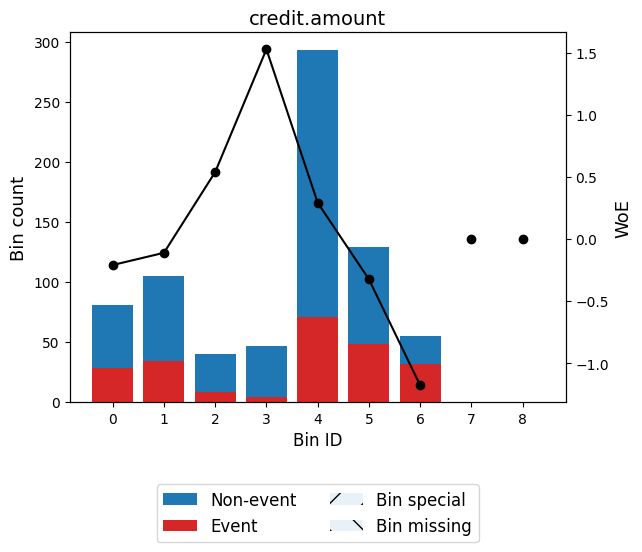

In [53]:
binning_table.plot(metric="woe")

**Por tasa de evento**

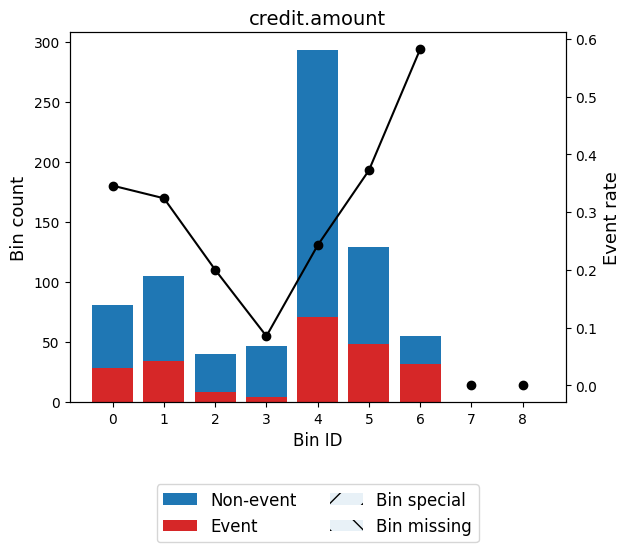

In [54]:
binning_table.plot(metric="event_rate")

La relación entre credit.amount y la tasa de evento (impago) es no lineal.

Cojo la tasa de evento (% de 1) ➡️ 30%. Trazo una línea:

 * Tramo 2,3 y 4 tienen un % < 30
 * Tramo 5,6 tienen un % bastante > a 30%, por lo que si alguien cae en este tramo es muy probable de que sea malo

----
####  Transformación WOE

#### ➡ Data

Ahora podemos aplicar esta tramificación óptima a la variable original y obtener la variable transformada WOE (que será una variable continua que utilizaremos en el modelode regresión)

In [56]:
# Transformación WOE
x_woe = optb.transform(X, metric="woe")
pd.Series(x_woe).value_counts().sort_index()

-1.177540     55
-0.324050    129
-0.209210     81
-0.110979    105
 0.292700    293
 0.538997     40
 1.527608     47
dtype: int64

Creo una nueva variable 'x_woe', a cada una de las categorías le asignamos su valor WOE, hay 7 valores diferentes

Fíjate que ahora hemos conseguido "linealizar" la relación entre la variable trasnformada Woe y la propensión al impago 

In [57]:
pd.crosstab(x_woe,Y,normalize=0).round(3)

col_0,0,1
row_0,,
-1.177540,0.418,0.582
-0.324050,0.628,0.372
-0.209210,0.654,0.346
-0.110979,0.676,0.324
0.292700,0.758,0.242
0.538997,0.800,0.200
1.527608,0.915,0.085


Text(0, 0.5, 'porcentaje de impago')

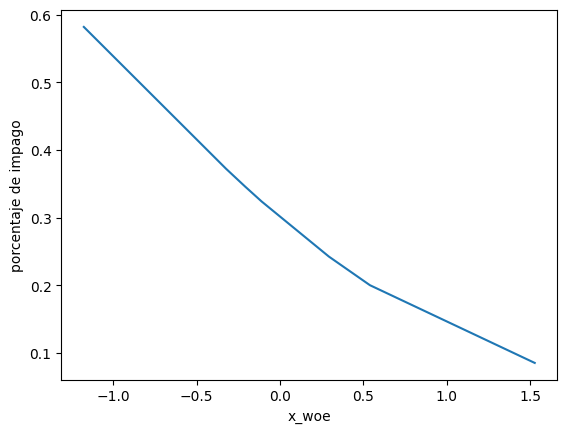

In [58]:
fig, ax = plt.subplots()
ax.plot(pd.crosstab(x_woe,Y,normalize=0).iloc[:,1])
ax.set_xlabel("x_woe")
ax.set_ylabel("porcentaje de impago")

#### ➡ Test

Nótese que para hacer la validación deberíamos hacer exactamente la misma transformación WOE, con la misma tramificación, al conjunto test. Para ello debemos aplicar la transformación optima calculada con el conjunto de entrenamiento, pero sobre la muestra de validación 

In [ ]:
# Transformación WOE en el conjunto test
x_test_woe = optb.transform(dt_test[variable].values, metric="woe")
pd.Series(x_test_woe).value_counts().sort_index()

Nótese que **no** estamos calculando una nueva tramificación para el conjunto de test, sino aplicando la tramificación obtenida con el conjunto de entrenamiento.    
En realidad si hiciéramos una tramificación óptima con el conjunto de test no tendría porqué salir igual que la estimada para el conunto de entrenamiento, como se puede comprobar a continuación

In [59]:
variable="credit.amount"
X_test=dt_test[variable].values
Y_test=dt_test['y'].values
optb_test = OptimalBinning(name=variable, dtype="numerical")
optb_test.fit(X_test, Y_test)
print(optb_test.splits)
binning_table_test = optb_test.binning_table
binning_table_test.build()

[1.88570279 1.95576465 1.99013698 2.18055654 2.20836258]


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.89)",15,0.060,12,3,0.200000,0.538997,0.015400,0.001902
1,"[1.89, 1.96)",29,0.116,23,6,0.206897,0.496437,0.025531,0.003159
2,"[1.96, 1.99)",37,0.148,27,10,0.270270,0.145954,0.003058,0.000382
3,"[1.99, 2.18)",140,0.560,98,42,0.300000,0.0,0.000000,0.000000
4,"[2.18, 2.21)",15,0.060,9,6,0.400000,-0.441833,0.012624,0.001565
5,"[2.21, inf)",14,0.056,6,8,0.571429,-1.13498,0.082151,0.009751
6,Special,0,0.000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,250,1.000,175,75,0.300000,,0.138764,0.016759


Nótese que con el conjunto de test se han obtenido sólo 6 tramos y con diferentes puntos de corte ( y diferentes WOE), por eso es necesario no hacer una nueva tramificación al conjunto de test sino aplicar la tramificación obtenida usando en el conjunto de entrenamiento

---
## Tramificación de la duración en meses

In [60]:
variable="duration.in.month"
X=dt_train[variable].values
Y=dt_train['y'].values

optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")

optb.fit(X, Y)
optb.splits

array([ 7.5, 11.5, 15.5, 34.5, 43.5])

In [61]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 7.50)",65,0.086667,59,6,0.092308,1.43848,0.123298,0.014207
1,"[7.50, 11.50)",70,0.093333,56,14,0.200000,0.538997,0.023955,0.002959
2,"[11.50, 15.50)",192,0.256000,145,47,0.244792,0.279288,0.018797,0.002342
3,"[15.50, 34.50)",293,0.390667,195,98,0.334471,-0.159266,0.010213,0.001275
4,"[34.50, 43.50)",83,0.110667,49,34,0.409639,-0.481838,0.027840,0.003447
5,"[43.50, inf)",47,0.062667,21,26,0.553191,-1.060872,0.080155,0.009574
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,750,1.000000,525,225,0.300000,,0.284258,0.033804


In [62]:
print("IV= ", binning_table.iv.round(3))
print("Gini= ", binning_table.gini.round(3))


IV=  0.284
Gini=  0.269


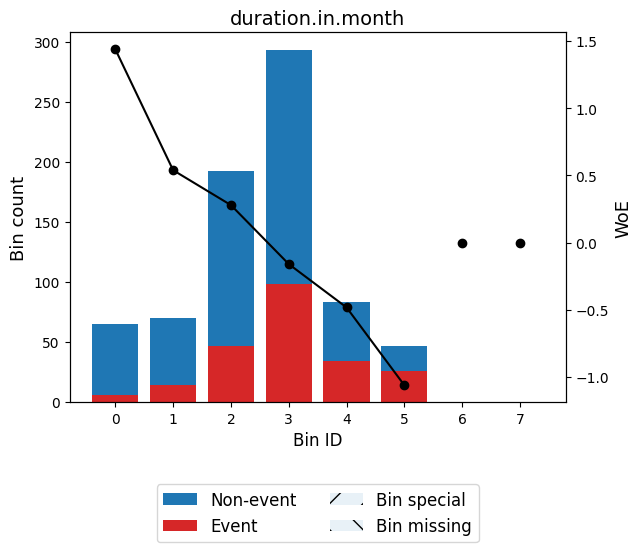

In [63]:
binning_table.plot(metric="woe")

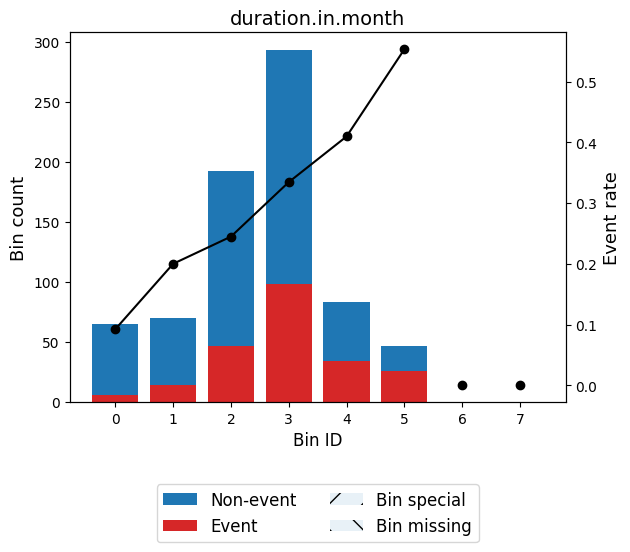

In [64]:
binning_table.plot(metric="event_rate")

In [65]:
# Transformación WOE
x_woe = optb.transform(X, metric="woe")
pd.Series(x_woe).value_counts().sort_index

<bound method Series.sort_index of -0.159266    293
 0.279288    192
-0.481838     83
 0.538997     70
 1.438480     65
-1.060872     47
dtype: int64>

---
---
# Agrupción de niveles en variables Vbles Categóricas

En realidad, cuando tenemos variables categóricas, no es necesario tramificar, pero sí hacer una agrupación de los diferentes niveles de forma que se maximice el *valor de información*

## Agrupación de la variable  *purpose*

In [66]:
variable_cat = "purpose"
X_cat = dt_train[variable_cat].values
Y_cat = dt_train['y'].values

dt_train[variable_cat].value_counts()

radio/television       221
car (new)              170
furniture/equipment    134
car (used)              82
business                70
education               36
repairs                 13
others                  10
domestic appliances      9
retraining               5
Name: purpose, dtype: int64

In [67]:
optb = OptimalBinning(name=variable_cat, dtype="categorical", solver="mip",
                      cat_cutoff=0.1)

optb.fit(X_cat, Y_cat)
optb.splits

[array(['car (used)'], dtype=object),
 array(['radio/television'], dtype=object),
 array(['furniture/equipment'], dtype=object),
 array(['car (new)'], dtype=object),
 array(['business', 'education', 'repairs', 'others',
        'domestic appliances', 'retraining'], dtype=object)]

In [68]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[car (used)],82,0.109333,67,15,0.182927,0.649345,0.039579,0.004862
1,[radio/television],221,0.294667,172,49,0.221719,0.408376,0.044857,0.005568
2,[furniture/equipment],134,0.178667,92,42,0.313433,-0.063179,0.000722,0.000090
3,[car (new)],170,0.226667,109,61,0.358824,-0.266824,0.016941,0.002111
4,"[business, education, repairs, others, domesti...",143,0.190667,85,58,0.405594,-0.46509,0.044590,0.005524
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,750,1.000000,525,225,0.300000,,0.146688,0.018156


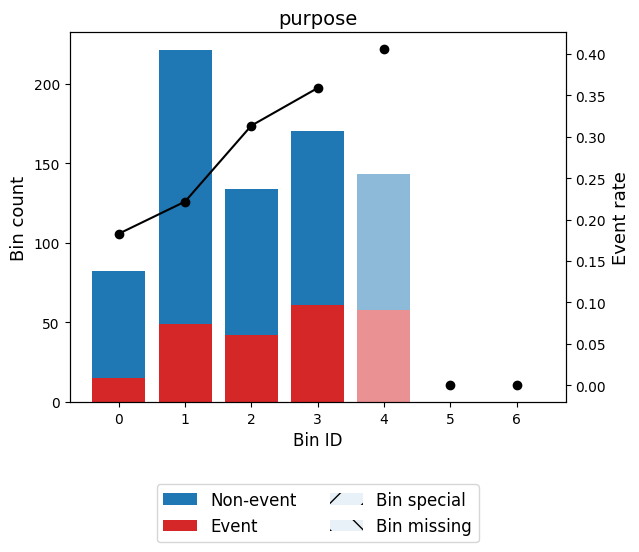

In [69]:
binning_table.plot(metric="event_rate")

In [70]:
x_woe = optb.transform(X_cat, metric="woe")
pd.Series(x_woe).value_counts()


 0.408376    221
-0.266824    170
-0.465090    143
-0.063179    134
 0.649345     82
dtype: int64

__________________________________________________________________________________________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________________________________________________________________________________________

__________________________________________________________________________________________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________________________________________________________________________________________

# Proceso de tramificación, agrupación y trasformación WOE Completo

Para no ir variable a variable se puede hacer todo el proceso completo

Proceso Entero



In [71]:
# 1) Definimos la lista de nombres señalando cualse de ellas son las categóricas
Y = dt_train['y'].values
X = dt_train.drop(columns=['Unnamed: 0','y']) #todas menos la primera que es el ID y la variable y
list_variables = X.columns.values.tolist()
list_categorical = X.select_dtypes(include=['object', 'category']).columns.values.tolist()

In [74]:
# 2) Definimos el criterio de selección, valor de la información es > 0,2
selection_criteria = {
    "iv": {"min": 0.02, "max": 1}
}

In [75]:
# 3) Definimos el proceso de Tramificación o BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_variables,
    selection_criteria=selection_criteria)


In [76]:
# 4) Obtenemos los tramos optimos de todas las Variables
dt_train_binned = binning_process.fit(X, Y)

Lo de foreign.worker es porque habría que eliminar esta variable, sólo el 3% de personas lo son

In [77]:
dt_train_binned.summary().sort_values('iv')

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
19,foreign.worker,categorical,OPTIMAL,False,1,0.0,0.0,0,0.0
17,number.of.people.being.liable.to.provide.maint...,numerical,OPTIMAL,False,2,0.000027,0.000003,0.001905,0.000002
18,telephone,categorical,OPTIMAL,False,2,0.006555,0.000819,0.039365,0.011947
16,job,categorical,OPTIMAL,False,3,0.006597,0.000824,0.035564,0.002399
10,present.residence.since,numerical,OPTIMAL,False,2,0.006759,0.000843,0.026667,0.005661
15,number.of.existing.credits.at.this.bank,numerical,OPTIMAL,False,2,0.007712,0.000964,0.04254,0.014758
8,personal.status.and.sex,categorical,OPTIMAL,False,3,0.011838,0.001478,0.055467,0.009888
9,other.debtors.or.guarantors,categorical,OPTIMAL,True,2,0.025861,0.003165,0.033651,0.013879
13,other.installment.plans,categorical,OPTIMAL,True,2,0.042562,0.00529,0.08254,0.070816
7,installment.rate.in.percentage.of.disposable.i...,numerical,OPTIMAL,True,3,0.082514,0.010266,0.148301,0.143666


In [78]:
# Ahora podemos ir sacando las tablas para cada variable
dt_train_binned.get_binned_variable("credit.amount").binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.93)",81,0.108000,53,28,0.345679,-0.20921,0.004915,0.000613
1,"[1.93, 1.98)",105,0.140000,71,34,0.323810,-0.110979,0.001762,0.000220
2,"[1.98, 1.99)",40,0.053333,32,8,0.200000,0.538997,0.013689,0.001691
3,"[1.99, 2.01)",47,0.062667,43,4,0.085106,1.527608,0.097961,0.011178
4,"[2.01, 2.12)",293,0.390667,222,71,0.242321,0.2927,0.031407,0.003912
5,"[2.12, 2.19)",129,0.172000,81,48,0.372093,-0.32405,0.019134,0.002381
6,"[2.19, inf)",55,0.073333,23,32,0.581818,-1.17754,0.115885,0.013703
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,750,1.000000,525,225,0.300000,,0.284752,0.033698


In [79]:
dt_train_binned.get_binned_variable("purpose").binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[retraining, car (used)]",87,0.116000,72,15,0.172414,0.721318,0.050836,0.006220
1,[radio/television],221,0.294667,172,49,0.221719,0.408376,0.044857,0.005568
2,"[furniture/equipment, domestic appliances]",143,0.190667,98,45,0.314685,-0.068993,0.000920,0.000115
3,[business],70,0.093333,45,25,0.357143,-0.259511,0.006591,0.000822
4,[car (new)],170,0.226667,109,61,0.358824,-0.266824,0.016941,0.002111
5,"[repairs, others, education]",59,0.078667,29,30,0.508475,-0.881199,0.068817,0.008334
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,750,1.000000,525,225,0.300000,,0.188962,0.023171


In [80]:
dt_train_binned.information()

optbinning (Version 0.17.3)
Copyright (c) 2019-2022 Guillermo Navas-Palencia, Apache License 2.0

  Statistics
    Number of records                    750
    Number of variables                   20
    Target type                       binary

    Number of numerical                    7
    Number of categorical                 13
    Number of selected                    13

  Time                                1.0887 sec



In [81]:
# las variables seleccionadas se pueden obtener con 'get_support'"Tarea Estudiantes_TarjetaPuntuacion"
dt_train_binned.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True, False,  True,  True,  True,  True, False, False, False,
       False, False])

In [82]:
# Podemos transformar las variables WOE
dt_train_woe=dt_train_binned.transform(X, metric="woe")

# Existe la posibilidad de obtener directamente las transformada si en lugar de usar fit, hubiésemos usado fit_transform 
# dt_train_binned = binning_process.fit_transform(X, Y)
# dt_train_binned.info()
# el resultado sería un data.frame con las X seleccionadas trasnsformadas WOE

In [83]:
dt_train_woe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 13 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   status.of.existing.checking.account                  750 non-null    float64
 1   duration.in.month                                    750 non-null    float64
 2   credit.history                                       750 non-null    float64
 3   purpose                                              750 non-null    float64
 4   credit.amount                                        750 non-null    float64
 5   savings.account.and.bonds                            750 non-null    float64
 6   present.employment.since                             750 non-null    float64
 7   installment.rate.in.percentage.of.disposable.income  750 non-null    float64
 8   other.debtors.or.guarantors                          750 non-null    f

In [84]:
dt_train_woe

,status.of.existing.checking.account,duration.in.month,credit.history,purpose,credit.amount,savings.account.and.bonds,present.employment.since,installment.rate.in.percentage.of.disposable.income,other.debtors.or.guarantors,property,age.in.years,other.installment.plans,housing
0,-0.336472,-0.481838,0.640779,0.408376,-0.324050,-0.213184,0.386234,0.237709,0.733153,0.380307,-0.513292,0.103678,0.200394
1,-0.336472,-0.159266,-0.107989,0.721318,-0.324050,0.664160,-0.405465,0.470943,-0.035349,0.380307,0.158722,0.103678,0.200394
2,1.117733,-0.159266,0.640779,0.408376,0.292700,-0.213184,-0.027857,-0.270514,-0.035349,-0.076961,-0.513292,0.103678,0.200394
3,1.117733,0.279288,0.640779,0.408376,0.538997,-0.213184,-0.027857,-0.270514,-0.035349,-0.574431,0.781943,0.103678,-0.552498
4,0.305382,0.279288,-0.107989,0.408376,0.292700,0.664160,0.237328,0.237709,-0.035349,-0.076961,0.474458,0.103678,0.200394
...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,-0.336472,-0.159266,-0.107989,0.408376,-0.110979,-0.213184,0.237328,-0.270514,0.733153,0.380307,-0.065203,0.103678,0.200394
746,1.117733,0.279288,-0.107989,-0.266824,0.292700,0.664160,0.237328,-0.270514,-0.035349,-0.574431,0.158722,0.103678,-0.552498
747,-0.336472,-0.481838,0.058411,-0.266824,0.292700,-0.135802,0.237328,-0.270514,-0.035349,-0.574431,-0.065203,0.103678,-0.552498
748,-0.336472,-1.060872,-1.200119,-0.881199,-1.177540,-0.135802,0.237328,0.237709,-0.035349,-0.574431,0.158722,-0.411980,-0.552498


In [85]:
# Ahora aplicaríamos la misma transformación pero al conjunto de test (si hubiera que puntuar a nuevos clientes haríamos lo mismo)

Y_test = dt_test['y'].values
X_test = dt_test.drop(columns=['Unnamed: 0','y']) #todas menos la primera que es el ID y la variable y

dt_test_woe=dt_train_binned.transform(X_test, metric="woe")
dt_test_woe.info()





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 13 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   status.of.existing.checking.account                  250 non-null    float64
 1   duration.in.month                                    250 non-null    float64
 2   credit.history                                       250 non-null    float64
 3   purpose                                              250 non-null    float64
 4   credit.amount                                        250 non-null    float64
 5   savings.account.and.bonds                            250 non-null    float64
 6   present.employment.since                             250 non-null    float64
 7   installment.rate.in.percentage.of.disposable.income  250 non-null    float64
 8   other.debtors.or.guarantors                          250 non-null    f

In [86]:
dt_test_woe

,status.of.existing.checking.account,duration.in.month,credit.history,purpose,credit.amount,savings.account.and.bonds,present.employment.since,installment.rate.in.percentage.of.disposable.income,other.debtors.or.guarantors,property,age.in.years,other.installment.plans,housing
0,-0.336472,-1.060872,-0.107989,-0.068993,-1.177540,-0.213184,-0.461635,0.470943,-0.035349,-0.076961,-0.070769,0.103678,0.200394
1,-0.877451,0.279288,-0.107989,-0.266824,-1.177540,-0.213184,0.237328,0.470943,-0.035349,0.138836,0.158722,0.103678,0.200394
2,1.117733,-0.159266,0.640779,0.408376,-0.324050,-0.213184,0.386234,-0.270514,-0.035349,-0.076961,-0.070769,0.103678,-0.408385
3,1.117733,0.279288,-0.107989,-0.259511,-0.110979,-0.213184,-0.027857,0.237709,-0.035349,0.380307,-0.070769,0.103678,0.200394
4,0.305382,0.538997,-0.107989,0.408376,-0.110979,-0.135802,0.237328,0.237709,-0.035349,0.380307,0.158722,0.103678,0.200394
...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,1.117733,0.279288,-0.107989,-0.266824,0.292700,0.664160,-0.027857,0.237709,-0.035349,-0.574431,-0.070769,0.103678,0.200394
246,-0.336472,0.279288,-0.107989,0.408376,-0.209210,-0.213184,0.237328,-0.270514,-0.035349,-0.076961,0.474458,0.103678,0.200394
247,-0.877451,-0.159266,0.640779,-0.266824,-0.110979,-0.213184,0.237328,-0.270514,-0.035349,-0.076961,0.158722,0.103678,0.200394
248,0.305382,1.438480,0.640779,-0.266824,-0.110979,-0.213184,0.237328,0.470943,-0.035349,0.380307,0.158722,0.103678,0.200394


# Estimación del Modelo

Ahora podemos calcular la tarjeta de puntuación. En los apuntes de clase definimos tanto los WOE, como los Odd ratio como la probabilidad de `evento` respecto al `no-evento` (malos clientes o impago=1 respecto a los buenos clientes o impago=0):

$$ odd = {{P}\over {(1-P)}} ~~ {,~~  siendo} ~~  {P=Prob(impago=1)} $$
 
 Y la fórmula para obtener la puntuación o los score debe ser una relación negativa con los odd ratio: cuanto mayor la probabilidad de impago (en relación a la de no impago), menor puntuación ha de tener: 

 $$ score {= offset - Factor}~·~{ln(odds)}$$

 para obtener los valores concretos de esta recta que transforma probabilidades a puntos (para conocer el valor de $offset$ y de $Factor$), hay que decidir de manera arbitraria una pendiente y un punto de la anterior recta. Para la pendiente suele establecerse cada cuántos puntos de score (**pdo_0**) que dobla el odd ratio: $ score - pdo_0 = {offset -Factor}~ ·{ln(2*odds)}$. Mientras que para establecer un punto de la recta se establece una puntuación o score arbitraria que se considere que debería tener un cliente con una calidad credicitica de *sobresaliente* (**scorecard_points**), y también el odd ratio que debería tener ese cliente de *sobresaliente* (**odds_0**). Así habría que establecer tres parámetros para transformar probabilidades de impago a puntuaciones, por ejemplo:   

* **pdo_0** =40
* **scorecard_points** =600 
* **odds_0** =1/50

La librería `optBinning` [librería OptBinning](http://gnpalencia.org/optbinning/), en realidad utiliza el módulo de `credit scoring` de `SAS-miner` como inspiración, y por eso define al revés tanto los WOE como los odd ratio, es decir `no-evento` en relación a `evento` (clientes buenos respecto a los malos, o no-impago respecto a impago, impago=0 respecto a impago=1). 
$$ odd^B = {{(1-P)}\over {P}} ~~ {,~~  siendo} ~~  {P=Prob(impago=1)} $$

Esto implica que la ecuación que transforma las probabilidades de impago en scores utilizando esta *odds<sup>B</sup>* debe tener pendiente positiva (cuanto mejor *odd<sup>B</sup>* mejor calidad crediticia tiene el cliente)

 $$ score= {offset + Factor} ~·~ {ln(odds^B)}$$
 
 Nótese que ahora habrá que establecer de nuevo los puntos de score que doblan el odd ratio (**pdo_0**), y también la puntuación o score considerada como de sobresaliente(**scorecard_points**) y el odd ratio que debería tener ese cliente de *sobresaliente* **odds_0 <sup>*B*</sup>**, con **odds_0 <sup>*B*</sup>** **= 1/odds_0**.

 Así para estimar la puntuación crediticia con `optBinning` hay que establecer tres parámetros para transformar probabilidades de impago a puntuaciones, por ejemplo:   

* **pdo_0** =40
* **scorecard_points** =600 
* **odds_0 <sup>*B*</sup>** = 50  (equivalente a **odds_0** =1/50 )




In [87]:

# Directamente con el método Scorecard
estimator = LogisticRegression(solver="lbfgs")

# Establecemos los parámetros para la transformación de probabilidades en puntos de calidad crediticia o score

pdo_0 =40
scorecard_points_0= 600 
odds_0_B= 50 # (equivalente a  odds_0 =1/50 )

tarjeta= Scorecard(binning_process=binning_process,
                   estimator=estimator,
                   scaling_method="pdo_odds",
                   scaling_method_params={"pdo":pdo_0, "odds": odds_0_B, "scorecard_points": scorecard_points_0})

tarjeta.fit(X, Y, show_digits=4)

tarjeta.information(print_level=2)

tarjeta.table(style="detailed")

Scorecard(binning_process=BinningProcess(categorical_variables=['status.of.existing.checking.account',
                                                                'credit.history',
                                                                'purpose',
                                                                'savings.account.and.bonds',
                                                                'present.employment.since',
                                                                'personal.status.and.sex',
                                                                'other.debtors.or.guarantors',
                                                                'property',
                                                                'other.installment.plans',
                                                                'housing',
                                                                'job',
                                                                'telephone',
                                                                'foreign.worker'],
                                         selection_criteria={'iv': {'...
                                                         'other.debtors.or.guarantors',
                                                         'present.residence.since',
                                                         'property',
                                                         'age.in.years',
                                                         'other.installment.plans',
                                                         'housing',
                                                         'number.of.existing.credits.at.this.bank',
                                                         'job',
                                                         'number.of.people.being.liable.to.provide.maintenance.for',
                                                         'telephone',
                                                         'foreign.worker']),
          estimator=LogisticRegression(), scaling_method='pdo_odds',
          scaling_method_params={'odds': 50, 'pdo': 40,
                                 'scorecard_points': 600})

In [90]:
# obtenmos las predicciones
Y_pred=tarjeta.predict_proba(X)[:,1]

# Calculamos la media
Y_pred.mean().round(5)


0.3

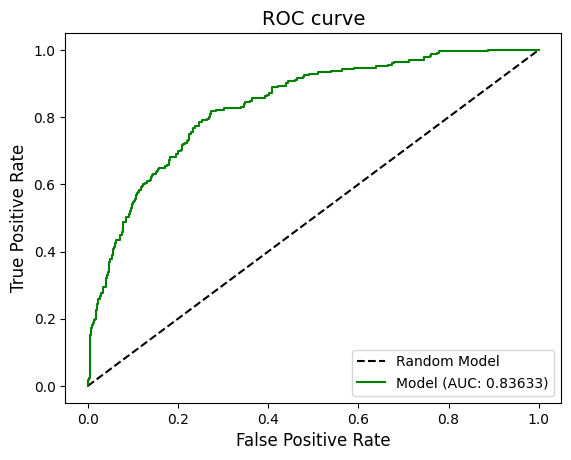

In [91]:
# Diagnosis Curva ROC
plot_auc_roc(Y,Y_pred)

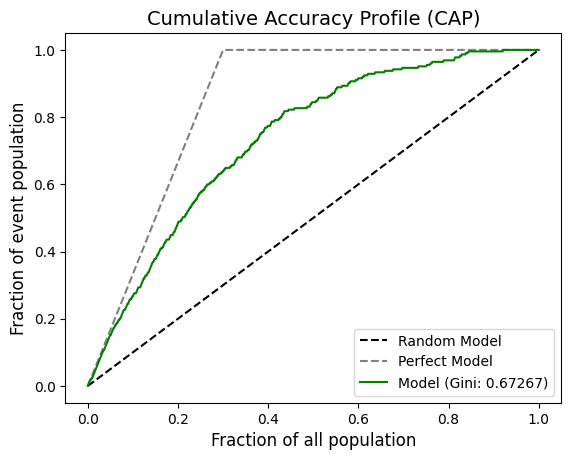

In [92]:
# Diagnosis Cumulative Accuracy Profile (CAP)

plot_cap(Y, Y_pred)

Punto de corte: 0,26

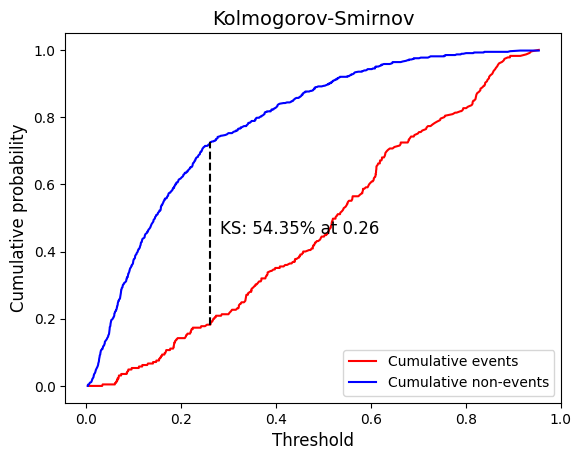

In [93]:
# Diagnosis  Plot Kolmogorov-Smirnov (KS)
plot_ks(Y, Y_pred)

In [94]:
#### OJO que la diagnosis debe hacerse fuera de la muestra de entrenamiento
# obtenmos las predicciones
Y_test_pred=tarjeta.predict_proba(X_test)[:,1]

# Calculamos la media
Y_test_pred.mean().round(5)

0.32241

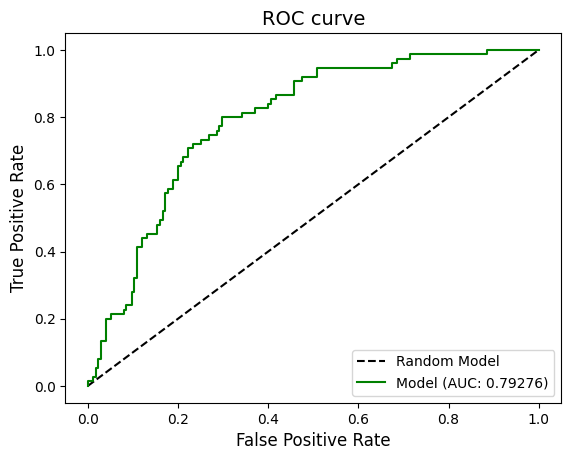

In [95]:
# Diagnosis Curva ROC
plot_auc_roc(Y_test,Y_test_pred)


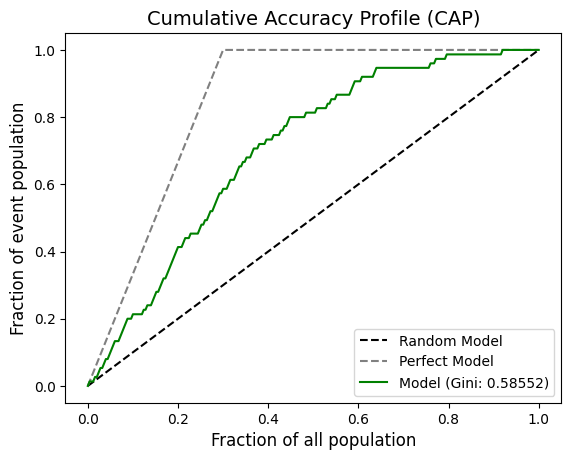

In [96]:
plot_cap(Y_test,Y_test_pred)

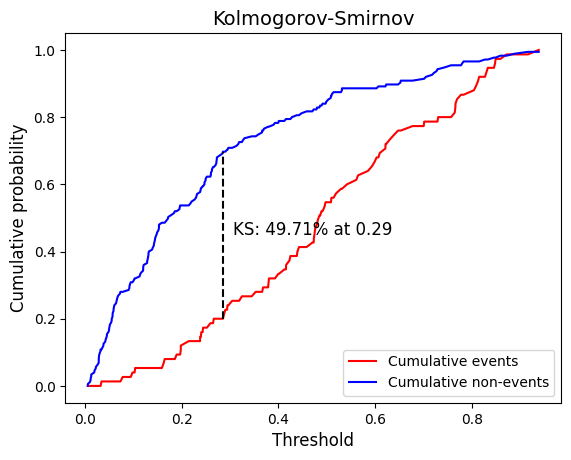

In [97]:
plot_ks(Y_test,Y_test_pred)

In [103]:
# Ahora vamos a calcular los score o puntuaciones.
#Que podemos hacer  con la función score
score = tarjeta.score(X)

print(score.min())
print(score.max())
print(score.mean())

# Transformación lineal según apuntes
# Factor= (pdo_0/log(2))
# Offset = scorecard_points_0+(pdo_0/log(2))*log(odds0_0)
# score= Offset - Factor *log(odds)

Factor= (pdo_0/np.log(2))
Offset = scorecard_points_0+Factor*np.log(1/odds_0_B)
score2= Offset-Factor*np.log(Y_pred/(1-Y_pred))

print(score2.min())
print(score2.max())
print(score2.mean())

datos_score=pd.DataFrame(np.transpose([score,score2, Y,Y_pred]), columns=['score','scoreManual','Y','Y_pred'])

# datos_score.to_excel("score_p1.xlsx")


200.25263663461163
702.2104795966648
443.975536257715
200.2526366346118
702.210479596665
443.97553625771513


Cuanto menos puntuación, mayor es la probabilidad de impago

In [109]:
datos_score.sort_values(by='scoreManual')

,score,scoreManual,Y,Y_pred
748,200.252637,200.252637,1.0,0.953250
596,218.219306,218.219306,1.0,0.937247
53,221.242397,221.242397,1.0,0.934094
301,227.905761,227.905761,1.0,0.926619
310,237.564239,237.564239,0.0,0.914394
...,...,...,...,...
326,659.959858,659.959858,0.0,0.007026
444,664.546985,664.546985,0.0,0.006493
515,695.634172,695.634172,0.0,0.003799
165,702.210480,702.210480,0.0,0.003391


Saber cómo se hace la transformación manual puede ayudarnos por ejemplo a la hora de establecer la `nota que determina el aprobado`. Imaginemos que utilizamos la frecuencia observada de impagos como probabilidad de corte 

In [110]:
Prob_Corte=Y.mean()
Score_Corte= Offset-Factor*np.log(Prob_Corte/(1-Prob_Corte))

print("La probabilida de corte de: ", Prob_Corte, " equivale a una puntuación de corte de: ", Score_Corte.round(2) )


La probabilida de corte de:  0.3  equivale a una puntuación de corte de:  423.14


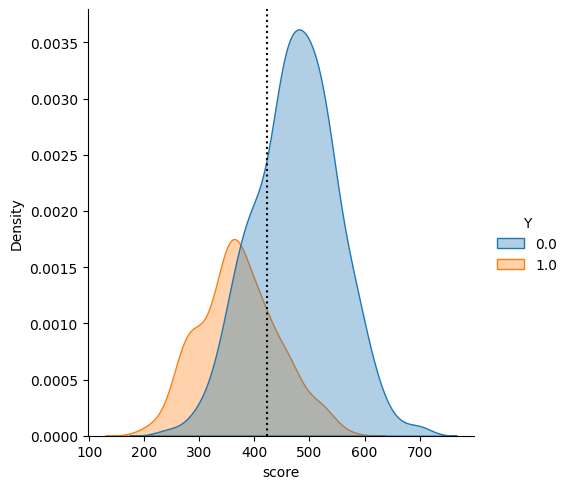

In [100]:
datos_score=pd.DataFrame(np.transpose([score,Y]), columns=['score','Y'])
sns.displot(data=datos_score, x='score', label="event", hue='Y', alpha=0.35,kind="kde", fill=True)
plt.axvline(Score_Corte, color='k', linestyle=":")

# Seguimiento del modelo: PSI (Population Stability Index)
El PSI es una medida de diferencia en la distribución de dos muestras, en nuestro caso entre la muestra utilizada para construir el modelo (entrenar y validar el modelo), y los nuevos datos que se vayan obteniendo con el transcurso del tiempo.  

Se aplica para detectar cuándo comienzan a verse diferencias entre las dos muestras (las puntuaciones de la muestra -train- y las puntuaciones obtenidas con los nuevos datos .... Cuando las distribuciones dejen de parecerse será el momento de revisar el modelo a tenor de los nuevos datos 

Como regla general 
  - **PSI <0.1**: No hay diferencias significativas entre las muestras de entrenamiento y los nuevos datos (resultado deseado, no se requiere más acciones)
  - **PSI entre 0.1 y 0.25** Hay cambio menores, valdría la pena revisar el modelo
  - **PSI >0.25** hay cambios importantes entre las dos muestras HAY QUE CAMBIAR EL MODELO 


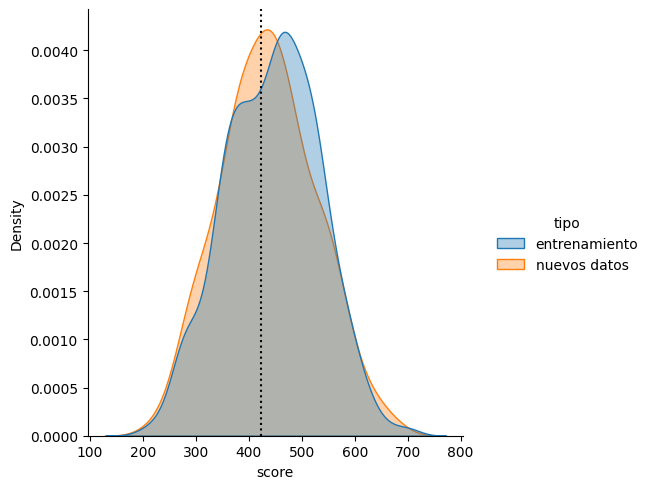

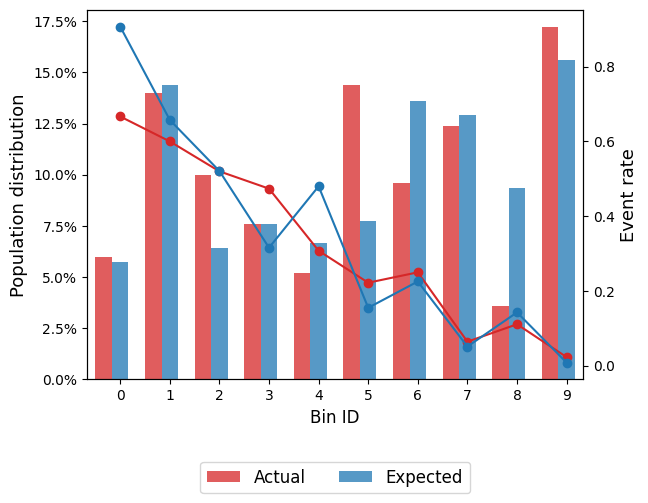

,Bin,Count A,Count E,Event rate A,Event rate E,statistic,p-value
0,"(-inf, 293.41)",15,43,0.666667,0.906977,4.898838,0.026875
1,"[293.41, 366.17)",35,108,0.600000,0.657407,0.379669,0.537780
2,"[366.17, 382.19)",25,48,0.520000,0.520833,0.000046,0.994604
3,"[382.19, 405.12)",19,57,0.473684,0.315789,1.551020,0.212985
4,"[405.12, 422.94)",13,50,0.307692,0.480000,1.240615,0.265352
5,"[422.94, 445.73)",36,58,0.222222,0.155172,0.674084,0.411631
6,"[445.73, 475.48)",24,102,0.250000,0.225490,0.065871,0.797447
7,"[475.48, 508.40)",31,97,0.064516,0.051546,0.076440,0.782181
8,"[508.40, 532.61)",9,70,0.111111,0.142857,0.067057,0.795671
9,"[532.61, inf)",43,117,0.023256,0.008547,0.551115,0.457863


In [111]:
# Supongamos que tenemos un conjunto de nuevos datos que hemos ido recopilando después de la puesta en producción del modelo,
# y queremos utilizar esos nuevos datos para saber si es necesario revisar el modelo o si por el contrario podemos seguir utilizándolo

# Como en la base de datos no disponemos de este tipo de datos voy a suponer simplemente que los datos de test son los nuevos datos,

dt_nuevosdatos= dt_test.copy() 


from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks,ScorecardMonitoring

# Defino la tarjeta a evalear
psi=ScorecardMonitoring(tarjeta, psi_method="cart",psi_n_bins=10)

# Valores nuevos
Y_nuevo = dt_nuevosdatos['y'].values
X_nuevo = dt_nuevosdatos.drop(columns=['y']) #todas menos la primera que es el ID y la variable y

# Valores de entrenamiento
Y = dt_train['y'].values
X = dt_train.drop(columns=['Unnamed: 0','y']) #todas menos la primera que es el ID y la variable y


# ¿se distibuyen igual las probabilidades esperadas?
score_train = tarjeta.score(X)
score_nuevo = tarjeta.score(X_nuevo)

datos_score_psi1=pd.DataFrame(np.transpose([score_train,Y]), columns=['score','Y'])
datos_score_psi1['tipo']='entrenamiento'

datos_score_psi2=pd.DataFrame(np.transpose([score_nuevo,Y_nuevo]), columns=['score','Y'])
datos_score_psi2['tipo']='nuevos datos'

datos_score_psi= pd.concat([datos_score_psi1,datos_score_psi2])
sns.displot(data=datos_score_psi, x='score', label="event", hue='tipo', alpha=0.35,kind="kde", fill=True,common_norm=False)
plt.axvline(Score_Corte, color='k', linestyle=":")




# Estimo el psi

psi.fit(X_actual=X_test, y_actual=Y_test, X_expected=X, y_expected=Y)

psi.psi_plot()
psi.psi_table()
psi.tests_table()


In [112]:
psi.system_stability_report()

-----------------------------------
Monitoring: System Stability Report
-----------------------------------

  Population Stability Index (PSI)


    PSI total:      0.1317 (Requires investigation)

         PSI bin  Count  Count (%)
    [0.00, 0.10)     10        1.0
    [0.10, 0.25)      0        0.0
    [0.25, Inf+)      0        0.0

  Significance tests (H0: actual == expected)

     p-value bin  Count  Count (%)
    [0.00, 0.05)      1        0.1
    [0.05, 0.10)      0        0.0
    [0.10, 0.50)      4        0.4
    [0.50, 1.00)      5        0.5

  Target analysis

               Metric  Actual Actual (%)  Expected Expected (%)
    Number of records     250          -       750            -
        Event records      75        0.3       225          0.3
    Non-event records     175        0.7       525          0.7

  Performance metrics

                 Metric   Actual  Expected  Diff A - E
     True positive rate 0.453333  0.555556   -0.102222
     True negative rate 0.85

In [113]:
psi.psi_variable_table(style="summary").sort_values('PSI')

,Variable,PSI
7,other.installment.plans,0.000047
6,other.debtors.or.guarantors,0.002435
8,present.employment.since,0.002666
1,credit.amount,0.005290
12,status.of.existing.checking.account,0.010448
2,credit.history,0.012226
9,property,0.012647
11,savings.account.and.bonds,0.014369
4,housing,0.015817
10,purpose,0.026675
